# Logistic Regression Code Demo

- **Objective**: Develop a logistic regression model for binary classification.
- **Dataset**: Titanic dataset, predicting passenger survival

**Variable Notes**

pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
train = pd.read_csv('train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [76]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Check for missing values

In [78]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

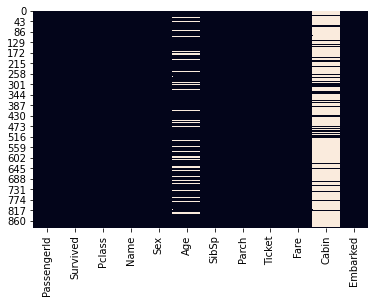

In [79]:
#Check for missing values
sns.heatmap(train.isnull(), cbar = False)

We have a lot of missing values for age, a potentially important variable in relation to survival, need to **impute** the data (replace missing values). Common missing value imputation techniques including taking the average of the variable value, binning, and using supervised Machine Learning methods such as KNN to predict and impute the missing values. I've attached a great article covering some of the various methods that exist out there for imputing data.

https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779

**Age** is an essential column with lots of missing values, can impute using a function that bases the average age based off of the passenger class.

In [80]:
def imputeAge(cols):
    """
    Function to impute missing values in the age column
    """
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age
train['Age'] = train[['Age','Pclass']].apply(imputeAge,axis=1)

In [81]:
#Now have no missing values for age
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

The **cabin** column is not essential, so dropping the column from the dataframe.

In [56]:
train.drop('Cabin',axis=1,inplace=True)

In [57]:
#No more cabin column
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


In [58]:
train.dropna(inplace=True)

Need to encode **categorical** data with **dummy** values for our model to be able to understand the data.

In [59]:
sex = pd.get_dummies(train['Sex'], drop_first = True)
embark = pd.get_dummies(train['Embarked'], drop_first = True)
train = pd.concat([train,sex,embark],axis=1)
train.drop(['Sex','Embarked','Name','Ticket','PassengerId'], axis=1, inplace=True)
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


## EDA

Explore the **response variable** in survived and check distribution of survived vs not survived

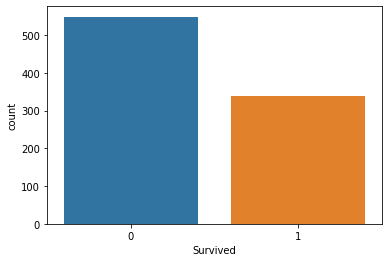

In [60]:
sns.countplot(x='Survived', data = train) #0 is survived, less survivors than diseased

Visualize relationship between Passenger Class and surivals.

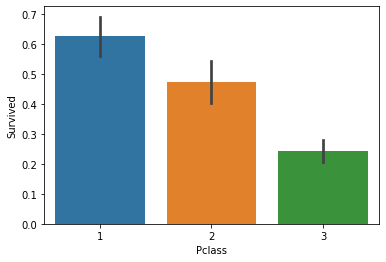

In [62]:
sns.barplot(x='Pclass', y='Survived', data = train)

## Train Test Split

In [68]:
X = train.drop('Survived', axis=1)
y = train['Survived']

In [69]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

## Model Building

In [70]:
from sklearn.linear_model import LogisticRegression
logModel = LogisticRegression() 
logModel.fit(X_train,y_train) #fitting the model
predictions = logModel.predict(X_test) #predicting on test set

/Applications/anaconda3/envs/deeplearning/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## Evaluate Model 

To evaluate the model we will be using a **Confusion Matrix**. There are 4 main components to a confusion matrix in this case.

- **True Positives (TP)**: These are cases in which we predicted yes (they did survive), and they did survive.
- **True Negatives (TN)**: We predicted no, and they did not survive.
- **False Positives (FP)**: We predicted yes, but they did not actually survive. (Type I error)
- **False Negatives (FN)**: We predicted no, but they actually did survive. (Type II error)

In this case the true positives are the top left and the true negatives are the bottom right (may differ depending on problem/table).

In [83]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,predictions) #146 true positives, 72 true negatives for our model

array([[146,  19],
       [ 30,  72]])